# The task is: please forecast the amount of orders with promotion in 4th and 8th week of forecast and without any promotion for the next 10 weeks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df.csv',index_col='Date',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2019-01-06 to 2021-02-28
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   no. of orders  113 non-null    float64
 1   promotion      113 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.6 KB


In [3]:
df.index.freq='W'
df.index

DatetimeIndex(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27',
               '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24',
               '2019-03-03', '2019-03-10',
               ...
               '2020-12-27', '2021-01-03', '2021-01-10', '2021-01-17',
               '2021-01-24', '2021-01-31', '2021-02-07', '2021-02-14',
               '2021-02-21', '2021-02-28'],
              dtype='datetime64[ns]', name='Date', length=113, freq='W-SUN')

# Descriptive analysis

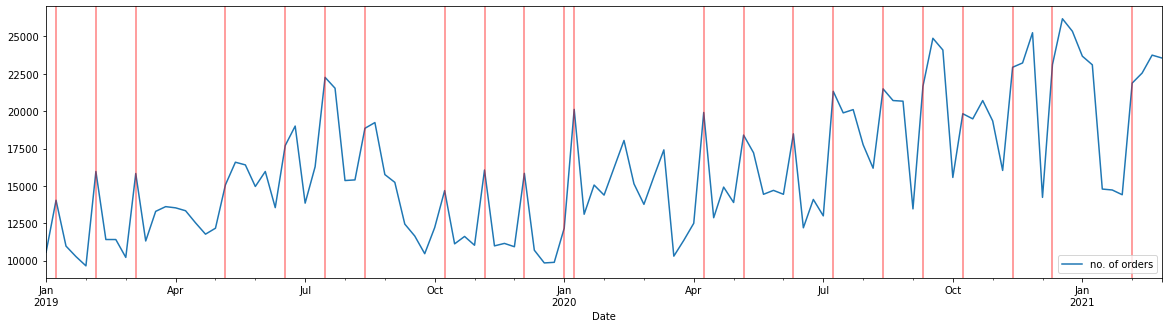

In [4]:
ax = df['no. of orders'].plot(figsize=(20,5),legend=True)
for day in df.query('promotion==1').index:
    ax.axvline(x=day,color='red',alpha=0.5);

Looking at this chart we can assume that in weeks with promotion the amount of orders are increasing

In [5]:
df = df
df['diff'] = df['no. of orders'].diff()
df['dynamics of change']=0.00
for i in range(len(df['diff'])):
    df['dynamics of change'][i] = round(df['diff'][i]/df['no. of orders'][i-1],2)
df.corr()['promotion']

no. of orders         0.283957
promotion             1.000000
diff                  0.702065
dynamics of change    0.784459
Name: promotion, dtype: float64

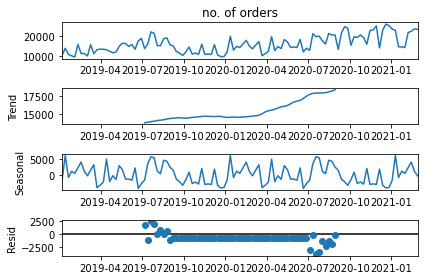

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['no. of orders'])
result.plot();

<AxesSubplot:xlabel='Date'>

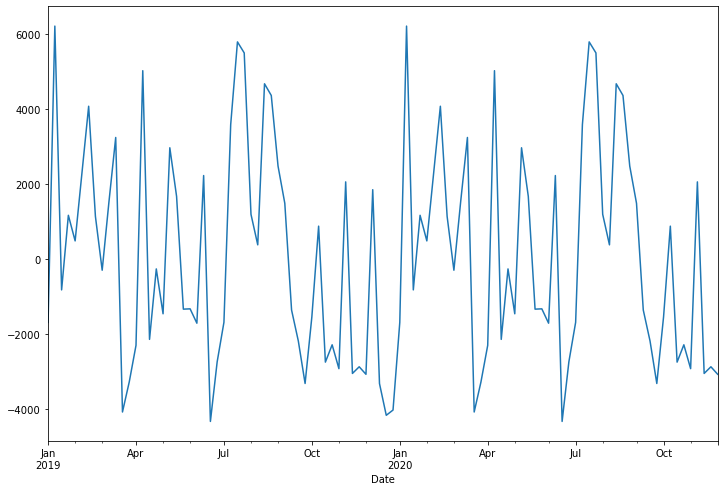

In [7]:
result.seasonal.iloc[:100].plot(figsize=(12,8))

Trend: it seams that between 2019-07 and 2020-08 we've got an upward trend with probably seasonality

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
adf_test(df['no. of orders']) #it's not a stationary data

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.032173
p-value                   0.741350
# lags used               8.000000
# observations          104.000000
critical value (1%)      -3.494850
critical value (5%)      -2.889758
critical value (10%)     -2.581822
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [10]:
first_diff=df['no. of orders'].diff(1).dropna()
adf_test(first_diff) #after diffrencing by 1 position we can make it stationary. It suppose that the "d" hyperparameter in ARIMAX model should be 1

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.816386e+00
p-value                 4.282724e-07
# lags used             7.000000e+00
# observations          1.040000e+02
critical value (1%)    -3.494850e+00
critical value (5%)    -2.889758e+00
critical value (10%)   -2.581822e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


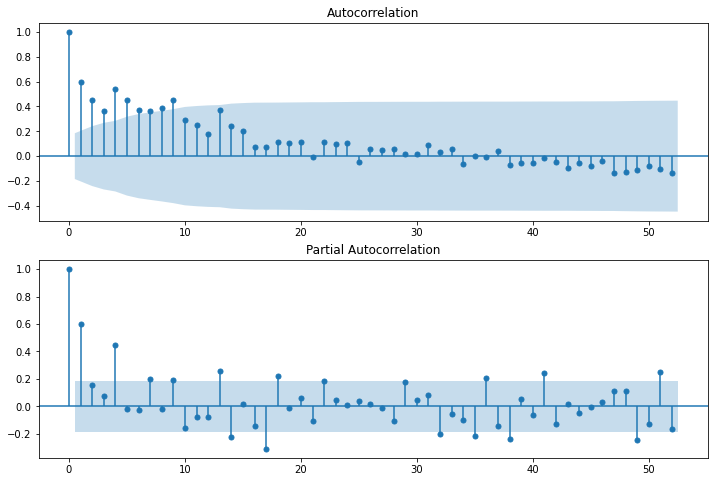

In [11]:
import statsmodels.api as sm
lags = 52

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['no. of orders'], lags=lags, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['no. of orders'], lags=lags, ax=ax2)

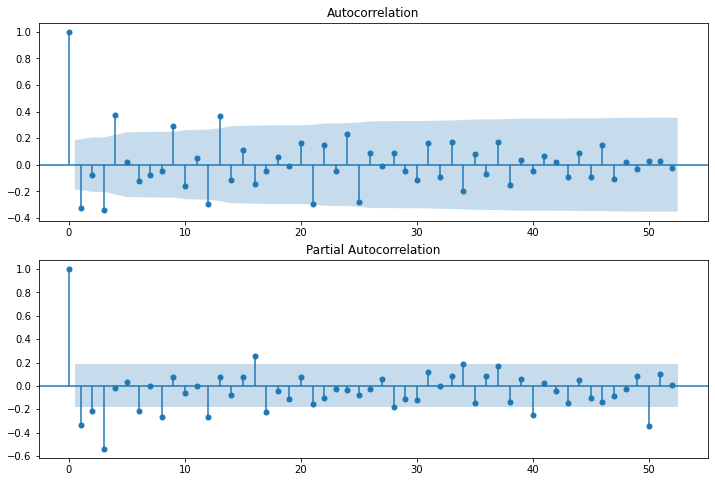

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=lags, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=lags, ax=ax2)# 

# Selecting p,d,q
d is the easiest = no of diffrencing to get the stationary dataset, in this case it is "1"
p (Auto Regression) value might be selected with lag length selected form the PACF model of stationary data, in our case it's clearly that within 3 lags the AR is significant
After looking at the autocorelation chart we can also exclude the seasonality factor


In [13]:
from pmdarima import auto_arima
auto_arima(df['no. of orders'],start_p=0, start_q=0,
                           max_p=10, max_q=10,
                           d=1,trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,information_criterion='aic').summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2165.545, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2157.016, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2137.676, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2163.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2134.623, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2135.582, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2136.163, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2134.360, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2134.884, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2127.324, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2124.748, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2123.523, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2125.185, Time=0.12 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -1049.246
Date:                Thu, 25 Mar 2021   AIC                           2116.492
Time:                        17:53:53   BIC                           2140.959
Sample:                             0   HQIC                          2126.419
                                - 113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    282.3854   1192.561      0.237      0.813   -2054.992    2619.762
ar.L1         -2.0980      0.250     -8.393      0.000      -2.588      -1.608
ar.L2         -1.8777      0.395     -4.755      0.000      -2.652      -1.104
ar.L3         -1.5064      0.308     -4.887      0.000      -2.111      -0.902
ar.L4         -1.1043      0.310     -3.558      0.000      -1.713      -0.496
ar.L5         -0.3085      0.185     -1.671      0.095      -0.670       0.053
ma.L1          1.7481      0.219      7.979      0.000       1.319       2.177
ma.L2          0.8185      0.221      3.700      0.000       0.385       1.252
sigma2      8.629e+06      0.059   1.47e+08      0.000    8.63e+06    8.63e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 7.90
Prob(Q):                              0.63   Prob(JB):                         0.02
Heteroskedasticity (H):               2.26   Skew:                            -0.32
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+25. Standard errors may be unstable.
"""

# choosing the best performing model
I've decided to grab 3 best models (with the lowest AIC) returned from auto_arima method, check it's MSE and RMSE and pick the best perfoming one for further forecasting 

In [14]:
train = df.iloc[:len(df)-10][['no. of orders','promotion']]
test = df.iloc[len(df)-10:][['no. of orders','promotion']]

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse

def check_rmse(train_set,exog_train,orders, test_set,exog_test):
    for i in range(len(orders)):
        model = SARIMAX(train_set,exog=exog_train, order=orders[i])
        results = model.fit()
        start = len(train_set)
        end = len(train_set) + len(test_set)-1
        predictions = results.predict(start=start,end=end,exog = exog_test).rename(f'{orders[i]}')
        print(f'MSE {orders[i]} is: {mse(test_set, predictions)}')
        print(f'RMSE {orders[i]} is: {rmse(test_set, predictions)}')
        print('\n')
        predictions.plot(figsize=(12,8),legend=True)

MSE (5, 1, 2) is: 27144947.352992572
RMSE (5, 1, 2) is: 5210.081319230303




C:\Users\Cezary.Sosnowski.CZAREK\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE (6, 1, 2) is: 28322359.624051593
RMSE (6, 1, 2) is: 5321.875573897946


MSE (4, 1, 2) is: 31363194.057388157
RMSE (4, 1, 2) is: 5600.285176434157




C:\Users\Cezary.Sosnowski.CZAREK\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE (3, 1, 3) is: 25789434.744868405
RMSE (3, 1, 3) is: 5078.329916898705




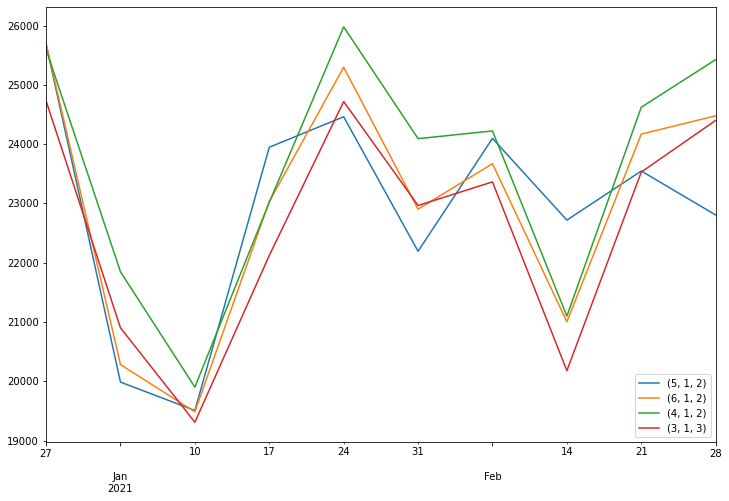

In [16]:
orders = [(5,1,2),(6,1,2),(4,1,2),(3,1,3)] #3 best performing models grabbed from AUTO_ARIMA and the best performing model with orders picked visually from PACF/ACF(3) and diffrencing (1)+ MA value from autoarima (3,1,3)
check_rmse(train['no. of orders'],train['promotion'],orders,test['no. of orders'],test['promotion'])

### we can that see the best performing model overall is (3,1,3)

In [17]:
order = (3,1,3)
model = SARIMAX(train['no. of orders'],exog=train['promotion'], order=order)
results = model.fit()
results.summary()

C:\Users\Cezary.Sosnowski.CZAREK\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          no. of orders   No. Observations:                  103
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -936.322
Date:                Thu, 25 Mar 2021   AIC                           1888.645
Time:                        17:53:56   BIC                           1909.644
Sample:                    01-06-2019   HQIC                          1897.148
                         - 12-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
promotion   3634.6955    689.680      5.270      0.000    2282.948    4986.443
ar.L1          0.6018      0.374      1.608      0.108      -0.132       1.335
ar.L2         -1.0628      0.137     -7.769      0.000      -1.331      -0.795
ar.L3          0.2057      0.361      0.570      0.568      -0.501       0.913
ma.L1         -1.1207      0.324     -3.458      0.001      -1.756      -0.486
ma.L2          1.2594      0.192      6.558      0.000       0.883       1.636
ma.L3         -0.5993      0.293     -2.044      0.041      -1.174      -0.025
sigma2      6.027e+06      0.004   1.66e+09      0.000    6.03e+06    6.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.95   Prob(JB):                         0.95
Heteroskedasticity (H):               1.59   Skew:                            -0.05
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.91e+25. Standard errors may be unstable.
"""

In [18]:
start = len(train)
end = len(train) + len(test)-1
exog_forecast = test[['promotion']]
predictions = results.predict(start=start,end=end,exog = exog_forecast).rename('ARIMAX model Predictions WITH EXOG')

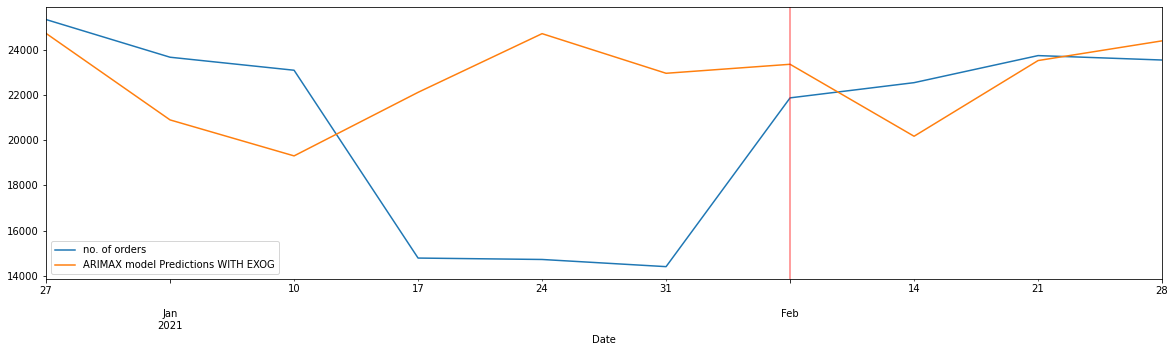

In [19]:
ax = test['no. of orders'].plot(figsize=(20,5),legend=True)
predictions.plot(legend=True)
for day in test.query('promotion==1').index:
    ax.axvline(x=day,color='red',alpha=0.5);

In [20]:

error1x = mse(test['no. of orders'], predictions)
error2x = rmse(test['no. of orders'], predictions)
mean_testset = test['no. of orders'].mean()
print(f'ARIMAX MSE Error: {error1x:11.10}')
print(f'ARIMAX RMSE Error: {error2x:11.10}')
print(f'Mean of test set: {mean_testset}')
print(f'relation of RMSE to mean of the set set: {round(error2x/mean_testset,2)}')

ARIMAX MSE Error: 25789434.74
ARIMAX RMSE Error: 5078.329917
Mean of test set: 20776.1084375
relation of RMSE to mean of the set set: 0.24


# True prediction +10 weeks 

In [21]:
df=df[['no. of orders','promotion']]
#retrain the model on the whole dataset
model = SARIMAX(df['no. of orders'],exog=df['promotion'], order=order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          no. of orders   No. Observations:                  113
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -1042.541
Date:                Thu, 25 Mar 2021   AIC                           2101.082
Time:                        17:53:56   BIC                           2122.830
Sample:                    01-06-2019   HQIC                          2109.906
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
promotion   3623.4193    725.224      4.996      0.000    2202.006    5044.833
ar.L1         -0.5348      0.411     -1.302      0.193      -1.340       0.270
ar.L2         -0.1845      0.239     -0.773      0.439      -0.652       0.283
ar.L3         -0.1759      0.263     -0.668      0.504      -0.692       0.340
ma.L1          0.1959      0.418      0.469      0.639      -0.623       1.015
ma.L2         -0.3188      0.240     -1.327      0.185      -0.790       0.152
ma.L3         -0.2293      0.332     -0.690      0.490      -0.880       0.422
sigma2      7.564e+06    1.2e+06      6.295      0.000    5.21e+06    9.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.87
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):               2.29   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+14. Standard errors may be unstable.
"""

In [22]:
exog_promotion = []
for i in range(0,10):
    exog_promotion.append(0)
    
exog_date = pd.date_range('2021-03-01', periods=10 , freq='W')

exog_df = pd.DataFrame({ 'Date': exog_date, 'promotion': exog_promotion })
exog_df=exog_df.set_index('Date')

In [23]:
fcast = results.predict(start=len(df),end=len(df)+10-1, exog=exog_df[['promotion']]).rename('Actual Fcast without promotion')

Text(0.5, 1.0, 'Forecast without promotion')

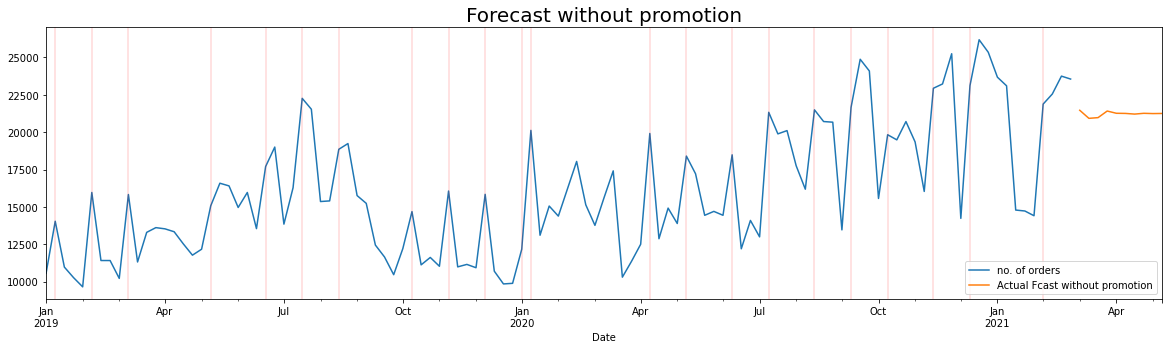

In [24]:
ax = df['no. of orders'].plot(figsize=(20,5),legend=True)
fcast.plot(legend=True)
for day in df.query('promotion==1').index:
    ax.axvline(x=day,color='red',alpha=0.15);
for day in exog_df.query('promotion==1').index:
    ax.axvline(x=day,color='red',alpha=0.15);
ax.set_title('Forecast without promotion', fontsize =20)

In [25]:
weeks_with_promotion = [3,5]
for i in weeks_with_promotion:
    exog_df.iloc[i].replace(0,1,inplace=True)

In [26]:
fcast1 = results.predict(start=len(df),end=len(df)+10-1, exog=exog_df[['promotion']]).rename('Actual Fcast with promotion')

Text(0.5, 1.0, 'Forecast without promotion')

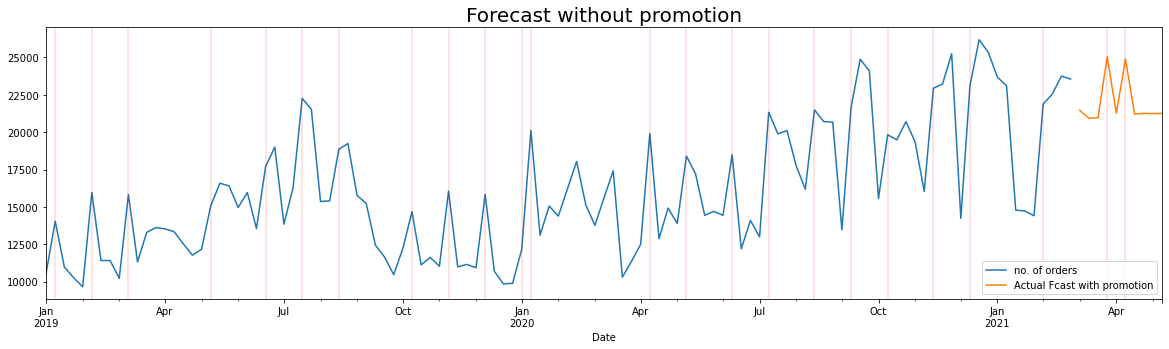

In [27]:
ax = df['no. of orders'].plot(figsize=(20,5),legend=True)
fcast1.plot(legend=True)
for day in df.query('promotion==1').index:
    ax.axvline(x=day,color='red',alpha=0.15);
for day in exog_df.query('promotion==1').index:
    ax.axvline(x=day,color='red',alpha=0.15);
ax.set_title('Forecast without promotion', fontsize =20)

In [28]:
forecast_df=pd.DataFrame([fcast,fcast1]).T
forecast_df.sum()

Actual Fcast without promotion    212241.201126
Actual Fcast with promotion       219488.039723
dtype: float64